# Set up

# Mục mới

In [15]:
!pip install pyvi


In [16]:
!pip install gensim


In [17]:
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0


In [18]:
import pandas as pd
import numpy as np
from collections import Counter
from pyvi import ViTokenizer
#from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
import re
import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
import pandas as pd

data_train = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv', encoding='utf-8',  sep=',')
data_test = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv', sep=',', encoding='utf-8')


# Train data

In [20]:
print(data_train.shape)
print(data_test.shape)

(3000, 35)
(600, 35)


In [21]:
data_train.head(10)

,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,...,ROOMS#PRICES,ROOMS#QUALITY,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,- Co view huong Ho tay- sach se-nhan vien tan ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,"Phòng ốc sạch, giường thoải mái, nhân viên thâ...",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
7,"gần Hồ Tây, view nhìn ra hồ lãng mạn, đi bộ dọ...",0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Hình thức không thể quyết định nội dung.H&atil...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Tôi ở đây lần này là lần thứ 4. Khi nhận phòng...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1


In [22]:
labels = data_train.iloc[:, 0].values
reviews = data_train['Review'].astype(str).values

In [23]:
# Mã hóa nhãn thành one-hot (labels -1, 0, 1 thành [1,0,0], [0,1,0], [0,0,1])
encoded_labels = []
for label in labels:
  if label == -1:
    encoded_labels.append([1,0,0])
  elif label == 0:
    encoded_labels.append([0,1,0])
  else:
    encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [24]:
# Tiền xử lý text: loại bỏ chữ số, chuyển thành chuỗi

from string import digits

reviews_processed = []
unlabeled_processed = []

for review in reviews:
  review_str = str(review)
  review_cool_one = ''.join([char for char in review_str if char not in digits])
  reviews_processed.append(review_cool_one)
print(reviews[8])
print(reviews_processed[8])


Hình thức không thể quyết định nội dung.H&atildey đến để tận hưởng & cảm nhận.Với tôi: Tuyệt vời!
Hình thức không thể quyết định nội dung.H&atildey đến để tận hưởng & cảm nhận.Với tôi: Tuyệt vời!


In [25]:
#  Tokenize tiếng Việt bằng ViTokenizer và tách từ
word_reviews = []
all_words = []
for review in reviews_processed:
  review = ViTokenizer.tokenize(review.lower())
  word_reviews.append(review.split())
print(word_reviews[8])

['hình_thức', 'không_thể', 'quyết_định', 'nội_dung', '.', 'h', '&', 'atildey', 'đến', 'để', 'tận_hưởng', '&', 'cảm_nhận', '.', 'với', 'tôi', ':', 'tuyệt_vời', '!']


In [26]:
# Tokenizer của Keras: fit, chuyển text thành sequence, và padding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


EMBEDDING_DIM = 400
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False, oov_token="<UNK>")
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index

data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [27]:
# #  Tải Word2Vec, tạo ma trận embedding cho vocab
# # Gán vector tương ứng cho từng từ trong từ điển
# import gensim
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess

# from gensim.models.keyedvectors import KeyedVectors
# word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/XuLyNNTN/vnex.model.bin', binary=True)

# vocabulary_size = min(len(word_index)+1, MAX_VOCAB_SIZE)
# embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
# print("Vocab size with <UNK>: ", vocabulary_size)

# for word, i in word_index.items():
#   if i >= MAX_VOCAB_SIZE:
#     continue  # chỉ bỏ những từ nằm ngoài giới hạn vocab

#   try:
#     embedding_vector = word_vectors[word]
#     embedding_matrix[i] = embedding_vector
#   except KeyError:
#     embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)


# del(word_vectors)

# # Tạo lớp embedding Keras sử dụng ma trận trên
# from keras.layers import Embedding
# embedding_layer = Embedding(input_dim=vocabulary_size,
#                             output_dim=EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             trainable=True)

In [28]:
!pip install tensorflow

# Test data

In [29]:
#Mục đích: Trích xuất nhãn cảm xúc và nội dung đánh giá từ tập dữ liệu test.


labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [30]:
# Mã hóa nhãn (label) thành one-hot
encoded_labels_test = []
for label in labels_test:
  if label == -1:
    encoded_labels_test.append([1,0,0])
  elif label == 0:
    encoded_labels_test.append([0,1,0])
  else:
    encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)

In [31]:
#Làm sạch văn bản (bỏ chữ số)
reviews_processed_test = []
unlabeled_processed_test = []

for review in reviews_test:
  review_str = str(review)
  review_cool_one = ''.join([char for char in review_str if char not in digits])
  reviews_processed_test.append(review_cool_one)

In [32]:
#Tokenize văn bản tiếng Việt
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
  review_test = ViTokenizer.tokenize(review_test.lower())
  word_reviews_test.append(review_test.split())

sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [33]:
print('Shape of X train and X validation tensor:', data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (3000, 300)
Shape of label train and validation tensor: (3000, 3)


# CNN


In [34]:
import pandas as pd
import numpy as np
from pyvi import ViTokenizer
# from gensim.models import KeyedVectors # KHÔNG CẦN NỮA
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- 1. Load dữ liệu ---
data_train = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv', encoding='utf-8', sep=',')
data_test = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv', sep=',', encoding='utf-8')

# Đảm bảo train_df và test_df được định nghĩa từ data_train và data_test
train_df = data_train.copy()
test_df = data_test.copy()

# --- 2. Chọn một nhãn (ví dụ: SERVICE#GENERAL) ---
label_col = 'SERVICE#GENERAL'

# --- 3. Lọc bỏ các dòng có nhãn 3 ---
# Bạn có thể muốn kiểm tra lại logic này nếu nhãn 3 là "Neutral" và bạn muốn giữ lại
# Hiện tại, nó sẽ chỉ giữ lại nhãn 0 và 1 (ví dụ: Negative và Positive)
train_df = train_df[train_df[label_col] < 3]
test_df = test_df[test_df[label_col] < 3]

# --- 4. Tiền xử lý văn bản ---
def preprocess_text(text):
    return ViTokenizer.tokenize(str(text).lower())

train_texts = train_df['Review'].apply(preprocess_text).tolist()
test_texts  = test_df['Review'].apply(preprocess_text).tolist()

train_labels = train_df[label_col].values
test_labels = test_df[label_col].values

# --- 5. Tokenize ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts + test_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

MAX_SEQUENCE_LENGTH = 100 # Cần đảm bảo giá trị này phù hợp với độ dài câu của bạn
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# --- 6. Encode label one-hot ---
# Kiểm tra lại số lượng lớp (num_classes) nếu bạn đã lọc bỏ nhãn 3
# Nếu bạn đã lọc bỏ nhãn 3, thì có thể chỉ còn 2 lớp (0 và 1)
# Nhưng nếu nhãn ban đầu là 0, 1, 2 thì num_classes = 3 vẫn đúng.
y_train = to_categorical(train_labels, num_classes=3)
y_test = to_categorical(test_labels, num_classes=3)

# --- 7. KHÔNG LOAD WORD2VEC NỮA ---
# w2v_path = '/content/drive/MyDrive/XuLyNNTN/vnex.model.bin'
# w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True) # Dòng này bị bỏ

# Xác định EMBEDDING_DIM thủ công
# Bạn có thể chọn giá trị phổ biến như 100, 200, 300
EMBEDDING_DIM = 100 # Đặt một giá trị cố định cho chiều embedding

word_index = tokenizer.word_index
num_words = len(word_index) + 1 # Bao gồm 1 cho các từ không có trong word_index (OOM)

# embedding_matrix KHÔNG CÒN ĐƯỢC TẠO TỪ WORD2VEC NỮA
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if word in w2v:
#         embedding_matrix[i] = w2v[word]

# Lớp Embedding sẽ tự học từ đầu
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=EMBEDDING_DIM,
                            # Bỏ tham số weights=[embedding_matrix]
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # Rất quan trọng: phải là True để embedding được học

# --- 8. Mô hình CNN ---
filter_sizes = [3, 4, 5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = embedding_layer(inputs)

conv_0 = Conv1D(num_filters, filter_sizes[0], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_0 = GlobalMaxPooling1D()(conv_0)
conv_1 = GlobalMaxPooling1D()(conv_1)
conv_2 = GlobalMaxPooling1D()(conv_2)

concat = Concatenate()([conv_0, conv_1, conv_2])
dropout = Dropout(drop)(concat)
output = Dense(units=3, activation='softmax', # Đảm bảo units=3 nếu bạn vẫn có 3 lớp sau to_categorical
               kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

# --- 9. Train ---
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[earlystop],
                    verbose=2)

# --- 10. Evaluate ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     430100      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 100, 100)     30100       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 100)     40100       ['embedding[0][0]']              
                                                                                              

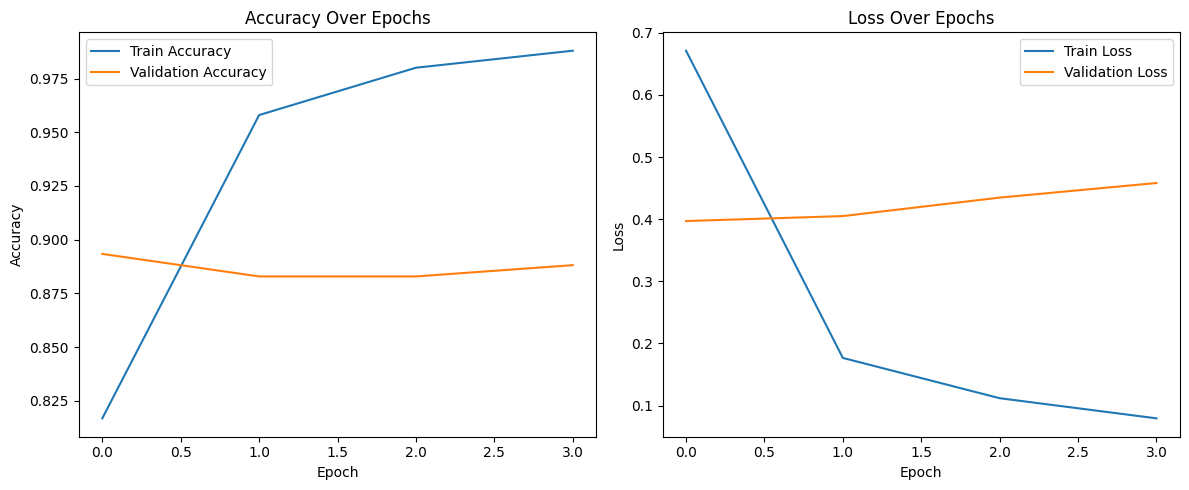

In [40]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ độ chính xác (accuracy)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Vẽ biểu đồ hàm mất mát (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Dự đoán trên tập test ---
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- In báo cáo phân loại ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# --- In ma trận nhầm lẫn ---
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


18/18 [==============================] - 0s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9021    0.9511    0.9259       184
           1     0.9518    0.9628    0.9573       349
           2     0.6400    0.4103    0.5000        39

    accuracy                         0.9213       572
   macro avg     0.8313    0.7747    0.7944       572
weighted avg     0.9146    0.9213    0.9160       572


Confusion Matrix:
[[175   5   4]
 [  8 336   5]
 [ 11  12  16]]


#Bidirectional LSTM + CNN

In [38]:
import pandas as pd
import numpy as np
from pyvi import ViTokenizer
# from gensim.models import KeyedVectors # Đã loại bỏ import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout, Dense
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Bidirectional, LSTM # Thêm lại import nếu bị xóa

# --- 1. Load dữ liệu ---
data_train = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv', encoding='utf-8', sep=',')
data_test = pd.read_csv('https://raw.githubusercontent.com/ds4v/absa-vlsp-2018/refs/heads/main/datasets/vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv', sep=',', encoding='utf-8')

# --- Đảm bảo train_df và test_df được khởi tạo từ data_train và data_test ---
# (Phần này bị thiếu trong code gốc, cần thêm vào)
train_df = data_train.copy()
test_df = data_test.copy()


# --- 2. Chọn một nhãn (ví dụ: SERVICE#GENERAL) ---
label_col = 'SERVICE#GENERAL'
# --- 3. Lọc bỏ các dòng có nhãn 3 ---
train_df = train_df[train_df[label_col] < 3]
test_df = test_df[test_df[label_col] < 3]

# --- 4. Tiền xử lý văn bản ---
def preprocess_text(text):
    return ViTokenizer.tokenize(str(text).lower())

train_texts = train_df['Review'].apply(preprocess_text).tolist()
test_texts  = test_df['Review'].apply(preprocess_text).tolist()

train_labels = train_df[label_col].values
test_labels = test_df[label_col].values

# --- 5. Tokenize ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts + test_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

MAX_SEQUENCE_LENGTH = 100
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# --- 6. Encode label one-hot ---
# Số lớp (num_classes) nên được xác định dựa trên giá trị lớn nhất trong nhãn + 1
# Nếu bạn đã lọc bỏ nhãn '3' và các nhãn còn lại là 0, 1, 2 thì num_classes vẫn là 3
# Nếu nhãn ban đầu là 1,2,3 và bạn lọc 3 thì còn 1,2 -> num_classes là 3 (0,1,2)
# Dựa trên code gốc, num_classes=3 có vẻ đúng với ý định nhãn là 0, 1, 2
y_train = to_categorical(train_labels, num_classes=3)
y_test = to_categorical(test_labels, num_classes=3)

# --- 7. KHÔNG LOAD WORD2VEC NỮA ---
# Các dòng sau đã được loại bỏ:
# w2v_path = '/content/drive/MyDrive/XuLyNNTN/vnex.model.bin'
# w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

# Xác định EMBEDDING_DIM thủ công khi không sử dụng Word2Vec
# Chọn một giá trị phổ biến, ví dụ 100 hoặc 300
EMBEDDING_DIM = 100 # Bạn có thể thay đổi giá trị này

word_index = tokenizer.word_index
num_words = len(word_index) + 1 # Bao gồm một vị trí cho các từ không xác định (out-of-vocabulary)

# embedding_matrix không còn được tạo từ Word2Vec nữa
# Các dòng sau đã được loại bỏ:
# embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
# for word, i in word_index.items():
#     if word in w2v:
#         embedding_matrix[i] = w2v[word]

# Lớp Embedding sẽ tự học từ đầu
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=EMBEDDING_DIM,
                            # Bỏ tham số weights=[embedding_matrix]
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # Rất quan trọng: phải là True để lớp học được các embedding

# from keras.layers import Bidirectional, LSTM, GlobalMaxPooling1D # Các import này đã có ở đầu rồi

# --- 8. Mô hình kết hợp CNN + BiLSTM ---
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding = embedding_layer(inputs)

# --- Nhánh CNN ---
filter_sizes = [3, 4, 5]
num_filters = 100
drop = 0.5

conv_0 = Conv1D(num_filters, filter_sizes[0], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_1 = Conv1D(num_filters, filter_sizes[1], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)
conv_2 = Conv1D(num_filters, filter_sizes[2], padding="same", activation='relu',
                kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_0 = GlobalMaxPooling1D()(conv_0)
conv_1 = GlobalMaxPooling1D()(conv_1)
conv_2 = GlobalMaxPooling1D()(conv_2)

cnn_branch = Concatenate()([conv_0, conv_1, conv_2])

# --- Nhánh BiLSTM ---
# units=64 là số lượng đơn vị LSTM/BiLSTM trong mỗi hướng
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
bilstm_pool = GlobalMaxPooling1D()(bilstm)

# --- Kết hợp CNN + BiLSTM ---
merged = Concatenate()([cnn_branch, bilstm_pool])
dropout = Dropout(drop)(merged)
output = Dense(units=3, activation='softmax', # Đảm bảo units=3 nếu số lớp đầu ra là 3
               kernel_regularizer=regularizers.l2(0.01))(dropout)

model = Model(inputs, output)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()


# --- 9. Train ---
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[earlystop],
                    verbose=2)

# --- 10. Evaluate ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     430100      ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 100, 100)     30100       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 100, 100)     40100       ['embedding_1[0][0]']            
                                                                                            

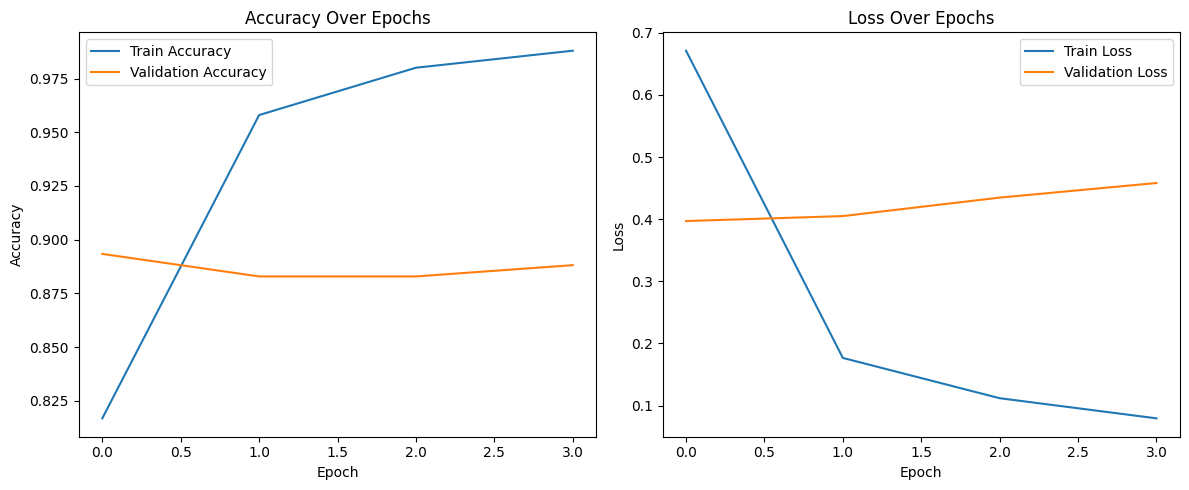

In [41]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ độ chính xác (accuracy)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Vẽ biểu đồ hàm mất mát (loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
# Dự đoán nhãn từ tập test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

18/18 [==============================] - 4s 173ms/step


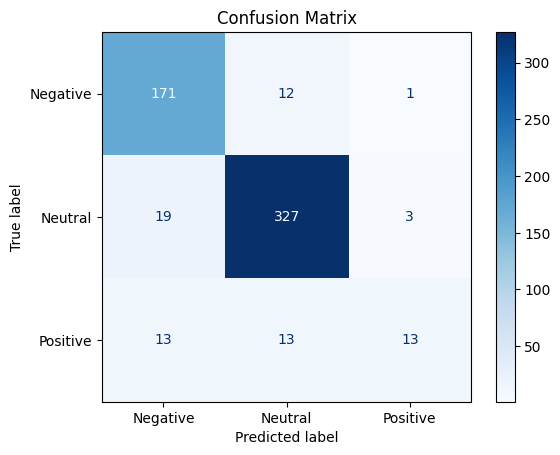

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#Bi-LSTM + Attention

In [39]:
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Attention, Concatenate, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

sequence_length = X_train.shape[1]  # dùng X_train để lấy chiều chuỗi
drop = 0.1

# 1. Định nghĩa Input + embedding
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)  # dùng embedding

# 2. BiLSTM
bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)

# 3. Self-Attention: giữa chính nó
attn = Attention()([bilstm, bilstm])

# 4. Kết hợp BiLSTM + Attention
concat = Concatenate()([bilstm, attn])

# 5. Làm phẳng, Dense, Dropout
flatten = Flatten()(concat)
dense = Dense(256, activation='tanh')(flatten)
dropout = Dropout(drop)(dense)

# 6. Output
output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dropout)

# 7. Model
model = Model(inputs, output)

# 8. Compile
adam = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

# 9. Callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 10. Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[earlystop],
    verbose=2
)

# 11. Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     430100      ['input_3[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 256)    234496      ['embedding_1[1][0]']            
 )                                                                                                
                                                                                                  
 attention (Attention)          (None, 100, 256)     0           ['bidirectional_1[0][0]',  